# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [14]:
!pip install datasets

Импорт необходимых библиотек

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [16]:
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [18]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [19]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [20]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [21]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [22]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

Задача 1

Архитектура модели

Так как у нас в новом датасете теперь 4 класса, то меняем параметр num_classes на 4

In [23]:
class CharLM(nn.Module):
  def __init__(
      self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
      aggregation_type: str = 'max'
  ):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, hidden_dim)
    self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
    self.linear = nn.Linear(hidden_dim, hidden_dim)
    self.projection = nn.Linear(hidden_dim, num_classes)

    self.non_lin = nn.Tanh()
    self.dropout = nn.Dropout(p=0.1)

    self.aggregation_type = aggregation_type

  def forward(self, input_batch) -> torch.Tensor:
    embeddings = self.embedding(input_batch)
    output, _ = self.rnn(embeddings)

    if self.aggregation_type == 'max':
      output = output.max(dim=1)[0]
    elif self.aggregation_type == 'mean':
      output = output.mean(dim=1)
    else:
      raise ValueError('Invalid aggregation type!')


    output = self.dropout(self.linear(self.non_lin(output)))
    prediction = self.projection(self.non_lin(output))

    return prediction



Обучим модель на новых данных

In [24]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
  print(f'Strating training for {aggregation_type}')
  losses = []
  acc = []

  model = CharLM(
      hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type
  ).to(device)
  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader,  desc=f'Training epoch {epoch}')):
      optimizer.zero_grad()
      logits = model(batch['input_ids'])
      loss = criterion(logits, batch['label'])
      loss.backward()
      optimizer.step()

      epoch_losses.append(loss.item())
      if i % eval_steps == 0:
        model.eval()
        acc.append(evaluate(model, eval_dataloader))
        model.train()
    losses.append(sum(epoch_losses) / len(epoch_losses))

  losses_type[aggregation_type] = losses
  acc_type[aggregation_type] = acc


Strating training for max


Training epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Strating training for mean


Training epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

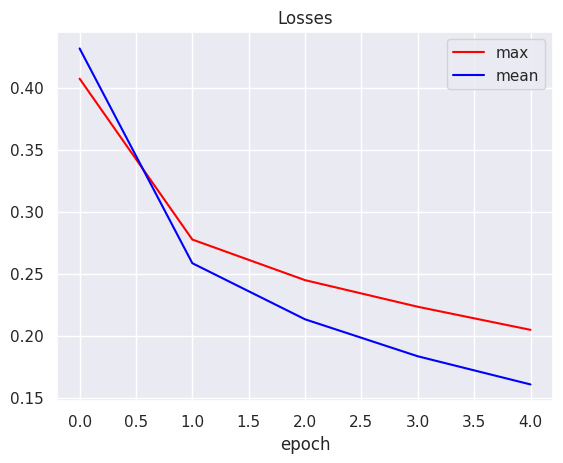

In [25]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)
plt.title('Losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.36
Лучшая accuracy для подхода mean: 90.56


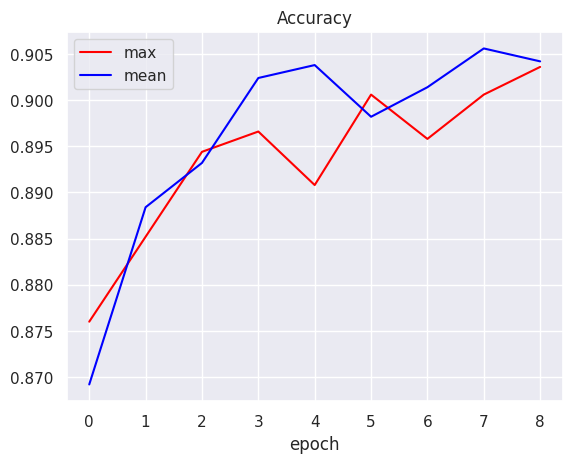

In [26]:
for (name, values), color in zip(acc_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f'Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

Получаем 2 интересных графика. Видим, что в n момент лосс для mean начали падать быстрее, чем для подхода max

Более интересный график для точности модели. Для подходов лучший accuracy получился 90.8, но при это у них разница всего 0.18. Это значит, что в принципе оба подхода +- дают одинаковый результат. Также по графику можно видеть, что точности сильно варьируются: то accuracy одного подхода было больше, то другого

90.8 - бейзлайн

**Эксперимент №1.**

Модель GRU. Заменяем RNN на GRU в архитектуре.

In [27]:
class CharLMGRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # Заменяем RNN на GRU
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.gru(embeddings)  # Используем GRU вместо RNN

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError('Invalid aggregation type!')

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))

        return prediction

In [28]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses_type_gru = {}
acc_type_gru = {}

for aggregation_type in ['max', 'mean']:
  print(f'Strating training for {aggregation_type}')
  losses = []
  acc = []

  model_gru = CharLMGRU(
      hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type
  ).to(device)
  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model_gru.parameters())

  for epoch in range(num_epoch):
    epoch_losses = []
    model_gru.train()
    for i, batch in enumerate(tqdm(train_dataloader,  desc=f'Training epoch {epoch + 1}')):
      optimizer.zero_grad()
      logits = model_gru(batch['input_ids'])
      loss = criterion(logits, batch['label'])
      loss.backward()
      optimizer.step()

      epoch_losses.append(loss.item())
      if i % eval_steps == 0:
        model_gru.eval()
        acc.append(evaluate(model_gru, eval_dataloader))
        model_gru.train()
    losses.append(sum(epoch_losses) / len(epoch_losses))

  losses_type_gru[aggregation_type] = losses
  acc_type_gru[aggregation_type] = acc


Strating training for max


Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Strating training for mean


Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

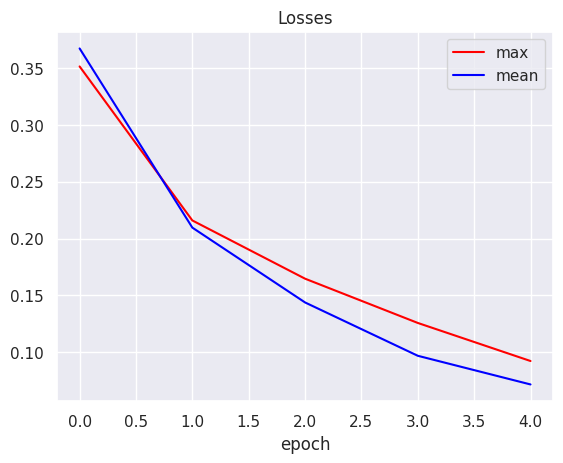

In [29]:
for (name, values), color in zip(losses_type_gru.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_gru[name])), losses_type_gru[name], color=color, label=name)
plt.title('Losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.34
Лучшая accuracy для подхода mean: 91.20


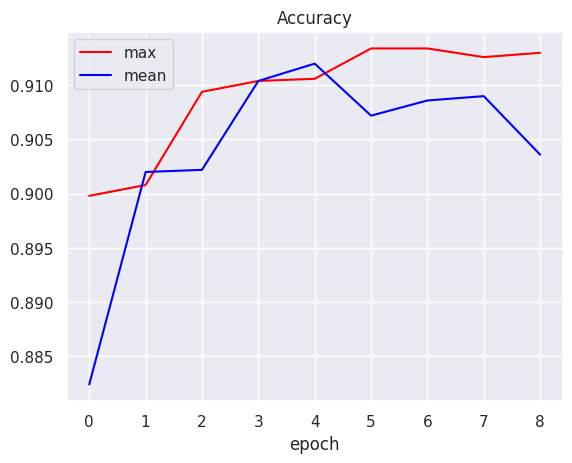

In [30]:
for (name, values), color in zip(acc_type_gru.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_gru[name][1:])), acc_type_gru[name][1:], color=color, label=name)
    print(f'Лучшая accuracy для подхода {name}: {(max(acc_type_gru[name]) * 100):.2f}')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

Как мы видим GRU дает результат лучше, чем RNN. Скорее всего это связано с проблемой исчезающих градиентов, ведь в GRU этот момент учтен

Эксперимент №2

Реализуем модель LSTM

Меняем RNN на LSTM

In [31]:
class CharLSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        # Заменяем RNN на LSTM
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError('Invalid aggregation type!')

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))

        return prediction

In [32]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses_type_lstm = {}
acc_type_lstm = {}

for aggregation_type in ['max', 'mean']:
  print(f'Strating training for {aggregation_type}')
  losses = []
  acc = []

  model_lstm = CharLSTM(
      hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type
  ).to(device)
  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model_lstm.parameters())

  for epoch in range(num_epoch):
    epoch_losses = []
    model_lstm.train()
    for i, batch in enumerate(tqdm(train_dataloader,  desc=f'Training epoch {epoch + 1}')):
      optimizer.zero_grad()
      logits = model_lstm(batch['input_ids'])
      loss = criterion(logits, batch['label'])
      loss.backward()
      optimizer.step()

      epoch_losses.append(loss.item())
      if i % eval_steps == 0:
        model_lstm.eval()
        acc.append(evaluate(model_lstm, eval_dataloader))
        model_lstm.train()
    losses.append(sum(epoch_losses) / len(epoch_losses))

  losses_type_lstm[aggregation_type] = losses
  acc_type_lstm[aggregation_type] = acc


Strating training for max


Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Strating training for mean


Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

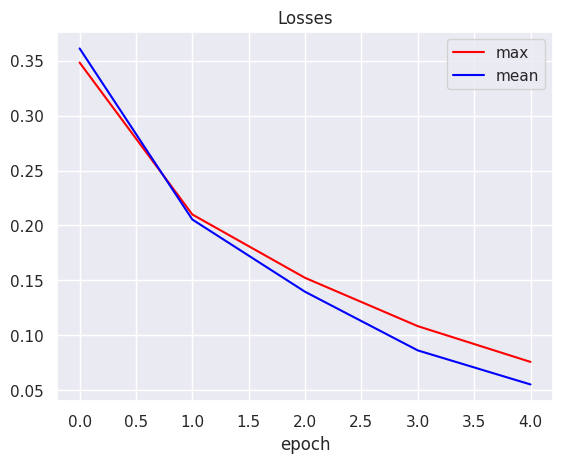

In [33]:
for (name, values), color in zip(losses_type_lstm.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_lstm[name])), losses_type_lstm[name], color=color, label=name)
plt.title('Losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.10
Лучшая accuracy для подхода mean: 91.50


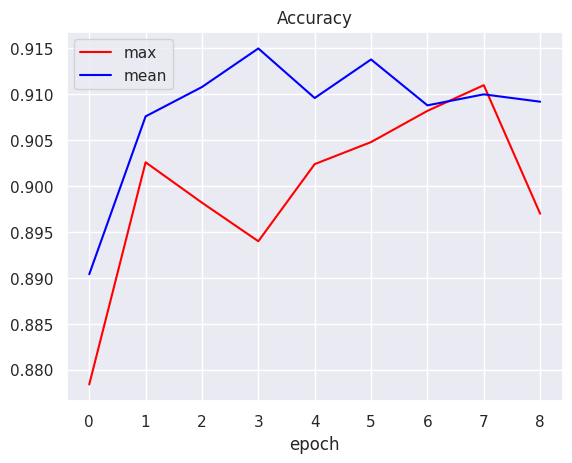

In [34]:
for (name, values), color in zip(acc_type_lstm.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_lstm[name][1:])), acc_type_lstm[name][1:], color=color, label=name)
    print(f'Лучшая accuracy для подхода {name}: {(max(acc_type_lstm[name]) * 100):.2f}')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

Эксперимент №3

Попробуем поменять количество слоев RNN


In [10]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 3
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        # Добавляем параметр num_layers для указания количества рекуррентных слоев
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError('Invalid aggregation type!')

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))

        return prediction

In [34]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
  print(f'Strating training for {aggregation_type}')
  losses = []
  acc = []

  model = CharLM(
      hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type
  ).to(device)
  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader,  desc=f'Training epoch {epoch+1}')):
      optimizer.zero_grad()
      logits = model(batch['input_ids'])
      loss = criterion(logits, batch['label'])
      loss.backward()
      optimizer.step()

      epoch_losses.append(loss.item())
      if i % eval_steps == 0:
        model.eval()
        acc.append(evaluate(model, eval_dataloader))
        model.train()
    losses.append(sum(epoch_losses) / len(epoch_losses))

  losses_type[aggregation_type] = losses
  acc_type[aggregation_type] = acc


Strating training for max


Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Strating training for mean


Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

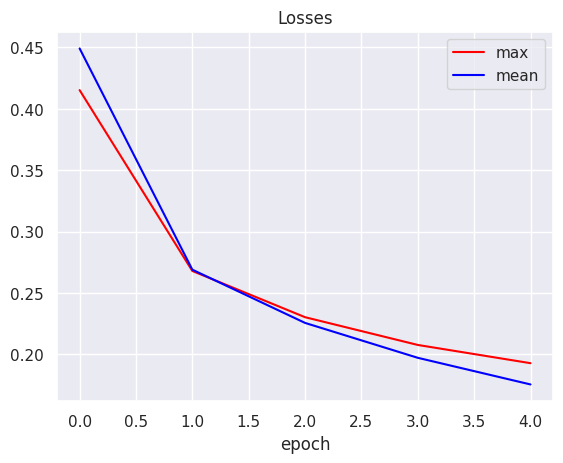

In [35]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)
plt.title('Losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.90
Лучшая accuracy для подхода mean: 91.02


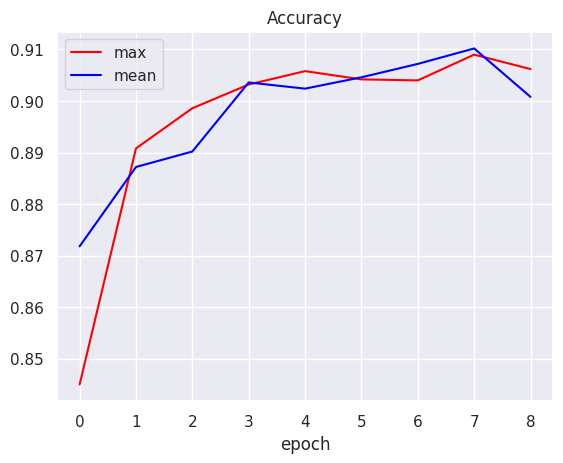

In [36]:
for (name, values), color in zip(acc_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f'Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [11]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
  print(f'Strating training for {aggregation_type}')
  losses = []
  acc = []

  model = CharLM(
      hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type
  ).to(device)
  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader,  desc=f'Training epoch {epoch+1}')):
      optimizer.zero_grad()
      logits = model(batch['input_ids'])
      loss = criterion(logits, batch['label'])
      loss.backward()
      optimizer.step()

      epoch_losses.append(loss.item())
      if i % eval_steps == 0:
        model.eval()
        acc.append(evaluate(model, eval_dataloader))
        model.train()
    losses.append(sum(epoch_losses) / len(epoch_losses))

  losses_type[aggregation_type] = losses
  acc_type[aggregation_type] = acc


Strating training for max


Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Strating training for mean


Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

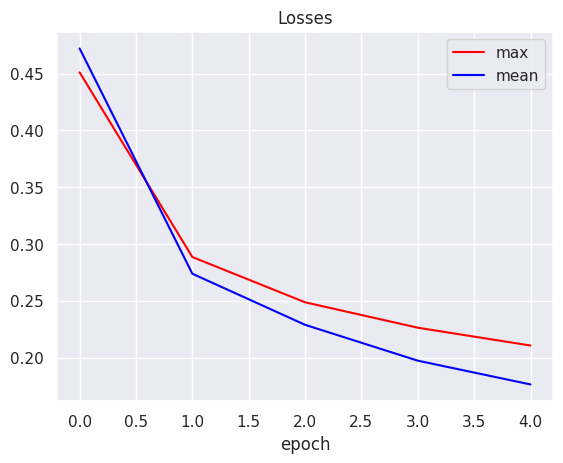

In [12]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)
plt.title('Losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.82
Лучшая accuracy для подхода mean: 90.78


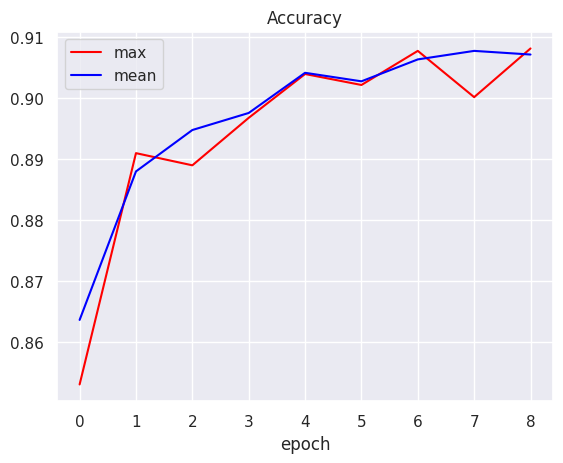

In [13]:
for (name, values), color in zip(acc_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f'Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

Вывод


In [56]:
print(f'Лучшая accuracy для модели "lstm" и подхода "mean": {(max(acc_type_lstm["mean"])):.3f}')


Лучшая accuracy для модели "lstm" и подхода "mean": 0.915


**Вывод:**

Я провел 3 эксперимента.

1.   Использовал GRU
2.   Использовал LSTM
3.   Добавил 2 и 3 слои в Vanilla RNN

**Результаты:**

**Vanilla RNN**

*   Лучшая accuracy для подхода max: 90.36
*   Лучшая accuracy для подхода mean: 90.56

**GRU**


*   Лучшая accuracy для подхода max: 91.34
*   Лучшая accuracy для подхода mean: 91.20

**LSTM**


*   Лучшая accuracy для подхода max: 91.10
*   Лучшая accuracy для подхода mean: 91.50



**Vanilla RNN с 2 слоями**


*   Лучшая accuracy для подхода max: 90.90
*   Лучшая accuracy для подхода mean: 91.02


**Vanilla RNN с 3 слоями**


*   Лучшая accuracy для подхода max: 90.82
*   Лучшая accuracy для подхода mean: 90.78

Как мы видим, лучший результат выдала модель LSTM, но и GRU не особо отстает в этом плане. Модели LSTM и GRU выдали лучшие результаты. Когда мы добавили еще одни слой в RNN, то результаты немного, но улучшились. Добавив еще один слой, результат не дал прироста.

Интересно, что значения Loss стабильно сходятся от модели к модели, а вот accuracy наоборот сильно скачет от модели к модели

Самая оптимальная модель: LSTM с подходом mean, так как она показывает наивысшую accuracy (91.50).

GRU также показывает хорошие результаты и может быть предпочтительным выбором, если важна скорость обучения, так как GRU обычно обучается быстрее, чем LSTM.

Vanilla RNN с увеличением количества слоев улучшает результаты, но всё же уступает более сложным архитектурам, таким как GRU и LSTM.

Таким образом, если цель — максимальная точность, то LSTM с подходом mean является лучшим выбором. Если важна скорость и простота, можно рассмотреть GRU.








